## Sinkhorn-type Algorithm for Constrained Optimal Transport

This tutorial implements a variant of the Sinkhorn algorithm to solve **entropic Optimal Transport (OT)** problems under additional **linear constraints**, based on [Muzellec et al., 2020](https://arxiv.org/abs/2001.09686).

Specifically, we implement:
- **Algorithm 1**: a Sinkhorn-type algorithm with dual updates for constraint enforcement.
- **Algorithm 2**: the **Sinkhorn-Newton-Sparse (SNS)** method, which refines Algorithm 1 using a Newton step in the reduced subspace to improve convergence and accuracy.

We demonstrate these methods in two settings:
- **1D OT** with custom marginals and L2-style constraints
- **2D OT** with Gaussian point clouds and random linear constraints

These experiments aim to visualize how constraints influence the transport plan and compare the convergence behavior of both algorithms.

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib import gridspec

### 1. Synthetic Data Generation for Constrained Optimal Transport

#### 1.1. Custom 1D Marginals

To test constrained Optimal Transport in a 1D setting, we construct **custom source and target marginals** using **Gaussian mixtures** over the interval \([0, 1]\):

- The **source distribution** \( r \) is a Gaussian centered at 0.7 with moderate spread.
- The **target distribution** \( c \) is a **mixture** of two narrower Gaussians, centered at 0.7 and 0.9, respectively.

These marginals are normalized to form valid probability distributions and plotted below:

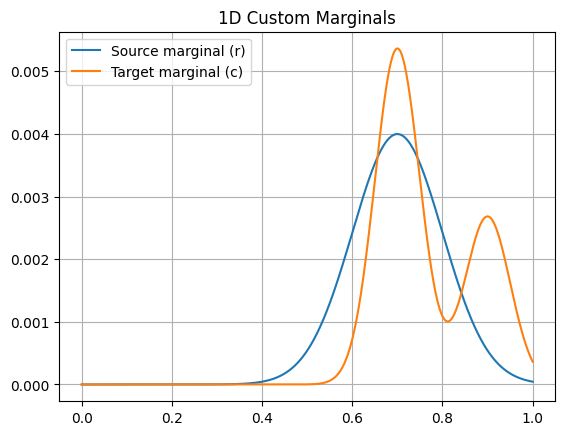

In [2]:
key = jax.random.PRNGKey(0)
n_samples = 1000
x = jnp.linspace(0, 1, n_samples).reshape(-1, 1)
y = jnp.linspace(0, 1, n_samples).reshape(-1, 1)


def gaussian(x, mu, sigma):
    return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)


r = gaussian(x.flatten(), 0.7, 0.1)
c = (
    2 * gaussian(x.flatten(), 0.7, 0.05) + gaussian(x.flatten(), 0.9, 0.05)
) / 3
r = r / jnp.sum(r)
c = c / jnp.sum(c)

plt.plot(x, r, label="Source marginal (r)")
plt.plot(y, c, label="Target marginal (c)")
plt.title("1D Custom Marginals")
plt.legend()
plt.grid(True)
plt.show()

#### 1.2. 2D Source and Target Point Clouds

To evaluate the constrained Sinkhorn algorithm in a 2D setting, we sample two **Gaussian blobs** in \(\mathbb{R}^2\):

- The **source distribution** is centered at \((1, 0)\)
- The **target distribution** is centered at \((-1, 0)\)

Each distribution contains \(n = 100\) points sampled from a standard normal and shifted accordingly. This setup creates a **structured transport challenge** with spatial displacement between the two distributions.

The figure below shows both clouds with color-coded points:
- 🔵 Blue: source
- 🔴 Red: target

This synthetic yet nontrivial example is used throughout the tutorial to test and compare constrained transport algorithms.

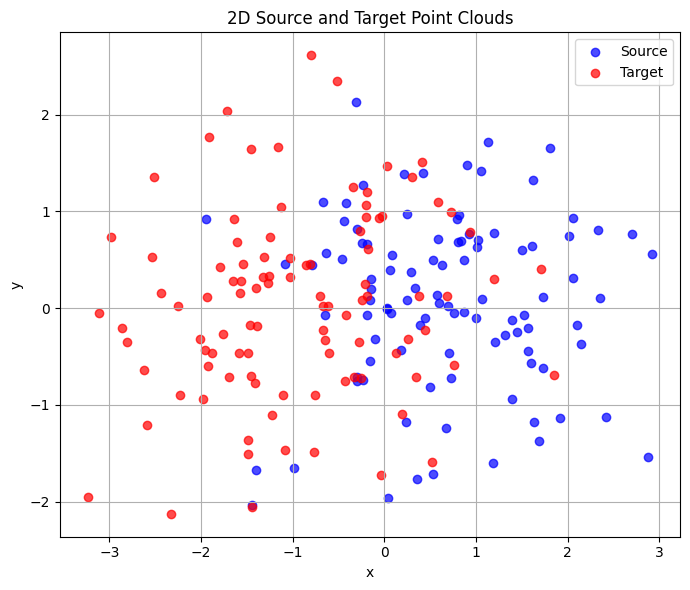

In [3]:
n = 100
key = jax.random.PRNGKey(0)
key, subkey1, subkey2 = jax.random.split(key, 3)

X = jax.random.normal(subkey1, (n, 2)) + jnp.array([1.0, 0.0])  # source
Y = jax.random.normal(subkey2, (n, 2)) + jnp.array([-1.0, 0.0])  # target


# Plot them
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c="blue", label="Source", alpha=0.7)
plt.scatter(Y[:, 0], Y[:, 1], c="red", label="Target", alpha=0.7)
plt.title("2D Source and Target Point Clouds")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Sinkhorn-type Algorithm with Linear Constraints

### 2.1. Defining `constrained_sinkhorn`: Sinkhorn-type Algorithm with Linear Constraints

This function implements a **constrained variant of the Sinkhorn algorithm**, designed to solve entropic Optimal Transport problems under **linear equality and inequality constraints**, as introduced in *Muzellec et al., 2020*.

It supports two algorithmic modes:
- **Algorithm 1**: Standard Sinkhorn-type algorithm with dual updates.
- **Algorithm 2 (SNS)**: An enhanced version with optional **Newton steps** in the dual space to accelerate convergence and enforce constraints more tightly.


#### **Inputs:**
- `C`: Cost matrix of shape *(n, n)*.
- `D_ineq`: List of inequality constraint matrices \( D_i \), enforcing \( P D_i^T \leq r \).
- `D_eq`: List of equality constraint matrices \( D_j \), enforcing \( P D_j^T = r \).
- `r`, `c`: Source and target marginals (probability vectors).
- `eta`: Entropic regularization parameter.
- `N_sinkhorn`: Number of Sinkhorn iterations.
- `N_newton`: Number of Newton refinement steps (if > 0, switches to Algorithm 2).
- `rho`: Threshold for sparsity in Newton steps.
- `xinit`, `yinit`, `ainit`: Optional initializations for dual variables.
- `return_iterates`: If provided, appends intermediate transport plans.

#### **Returns:**
- Dual potentials `x`, `y`
- Final transport plan `P`
- Dual constraint multipliers `(a_ineq, a_eq)`

#### **How it Works:**
- **Sinkhorn Iterations**: Iteratively updates dual variables and transport plan by alternating KL projections to match marginals and adjust for constraint violations.
- **Constraint Dual Updates**: Uses projected gradient ascent for inequality constraints and gradient ascent for equality constraints.
- **Newton Phase (Optional)**: Performs second-order optimization in the dual space using a block-structured Hessian to refine convergence.

In [4]:
def constrained_sinkhorn(
    C,
    D_ineq=[],
    D_eq=[],
    r=None,
    c=None,
    eta=1200,
    N_sinkhorn=100,
    N_newton=0,
    rho=1e-3,
    xinit=None,
    yinit=None,
    ainit=None,
    return_iterates=None,
):
    n = C.shape[0]
    m_ineq = len(D_ineq)
    m_eq = len(D_eq)
    m = m_ineq + m_eq

    # Combine constraint matrices
    Dm_list = D_ineq + D_eq
    Dm_tensor = jnp.stack(Dm_list)
    v = jnp.concatenate([jnp.ones(n), -jnp.ones(n), jnp.zeros(m)])

    x = jnp.zeros(n) if xinit is None else xinit
    y = jnp.zeros(n) if yinit is None else yinit
    a_ineq = jnp.zeros(m_ineq)
    a_eq = jnp.zeros(m_eq)

    def get_full_a():
        return jnp.concatenate([a_ineq, a_eq])

    z = None  # Used later for Newton steps

    # === Sinkhorn iterations ===
    for i in range(N_sinkhorn):
        a = get_full_a()
        dual_term = jnp.sum(a[:, None, None] * Dm_tensor, axis=0)

        P = jnp.exp(-eta * (C - dual_term - x[:, None] - y[None, :]))
        x += (jnp.log(r) - jnp.log(jnp.clip(P @ jnp.ones(n), 1e-8))) / eta

        dual_term = jnp.sum(a[:, None, None] * Dm_tensor, axis=0)
        P = jnp.exp(-eta * (C - dual_term - x[:, None] - y[None, :]))
        y += (jnp.log(c) - jnp.log(jnp.clip(P.T @ jnp.ones(n), 1e-8))) / eta

        Ku = P @ jnp.ones(n)
        residuals = jnp.array([Dm @ Ku - r for Dm in Dm_list])
        grad_ineq = jnp.array([jnp.sum(res) for res in residuals[:m_ineq]])
        grad_eq = jnp.array([jnp.sum(res) for res in residuals[m_ineq:]])

        # Paper-faithful dual updates
        a_ineq = jnp.maximum(a_ineq + 0.5 * grad_ineq, 0.0)
        a_eq = a_eq + 0.5 * grad_eq

        if return_iterates is not None:
            return_iterates.append(P)

    # === Newton iterations (optional) ===
    if N_newton > 0:
        a = get_full_a()
        z = jnp.concatenate([x, y, a])
        z = z - (z @ v) / (v @ v) * v

        for i in range(N_newton):
            x, y = z[:n], z[n : 2 * n]
            a = z[2 * n :]
            dual_term = jnp.sum(a[:, None, None] * Dm_tensor, axis=0)
            P = jnp.exp(-eta * (C - dual_term - x[:, None] - y[None, :]) - 1)
            P = jnp.where(P > rho, P, 0.0)

            grad_x = jnp.log(r) - jnp.log(jnp.clip(P @ jnp.ones(n), 1e-8))
            grad_y = jnp.log(c) - jnp.log(jnp.clip(P.T @ jnp.ones(n), 1e-8))
            Ku = P @ jnp.ones(n)
            grad_a = jnp.array([jnp.sum(Dm @ Ku - r) for Dm in Dm_list])
            grad = jnp.concatenate([grad_x, grad_y, grad_a])

            diag_x = eta * jnp.diag(P @ jnp.ones(n))
            diag_y = eta * jnp.diag(P.T @ jnp.ones(n))
            diag_a = jnp.eye(m)

            H = jnp.block(
                [
                    [diag_x, jnp.zeros((n, n)), jnp.zeros((n, m))],
                    [jnp.zeros((n, n)), diag_y, jnp.zeros((n, m))],
                    [jnp.zeros((m, n)), jnp.zeros((m, n)), diag_a],
                ]
            )
            H -= jnp.outer(v, v)
            delta_z = jnp.linalg.solve(H + 1e-6 * jnp.eye(H.shape[0]), -grad)
            z = z + 0.5 * delta_z

            if return_iterates is not None:
                return_iterates.append(P)

        x, y = z[:n], z[n : 2 * n]
        a = z[2 * n :]
        a_ineq, a_eq = a[:m_ineq], a[m_ineq:]

    return x, y, P, (a_ineq, a_eq)

### 2.2. Effect of Varying Constraint Strength on 1D Transport Plan

In this section, we illustrate how the strength of a **linear equality constraint** (here, a surrogate for an \( \ell_2 \)-type regularization) affects the structure of the optimal transport plan on a **1D problem**.

We define a simple scenario with:
- **Custom source and target marginals** on a 1D grid.
- **Squared Euclidean cost**.
- An additional **equality constraint** using the identity matrix as a proxy for an \( \ell_2 \)-norm control over the transport plan.

We vary the regularization parameter \( \eta = 1/\text{reg} \) to interpolate between:
- **Strict constraint enforcement** (small regularization).
- **Loose or no constraint** (large regularization).

The following four plots show how the transport plan evolves under different levels of constraint pressure:
- A **binding constraint** (very small reg) leads to minimal \( \ell_2 \)-norm transport.
- A **weaker constraint** allows the solution to spread more.
- The **unconstrained** case (large reg) reduces to the usual entropic OT, typically aligned with minimal \( \ell_1 \)-cost behavior.

These visualizations highlight the trade-off between adhering to external constraints and minimizing transport cost.

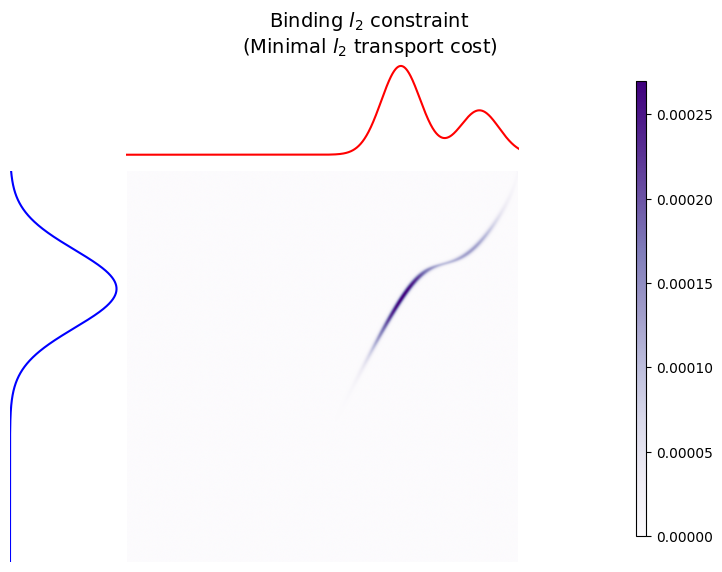

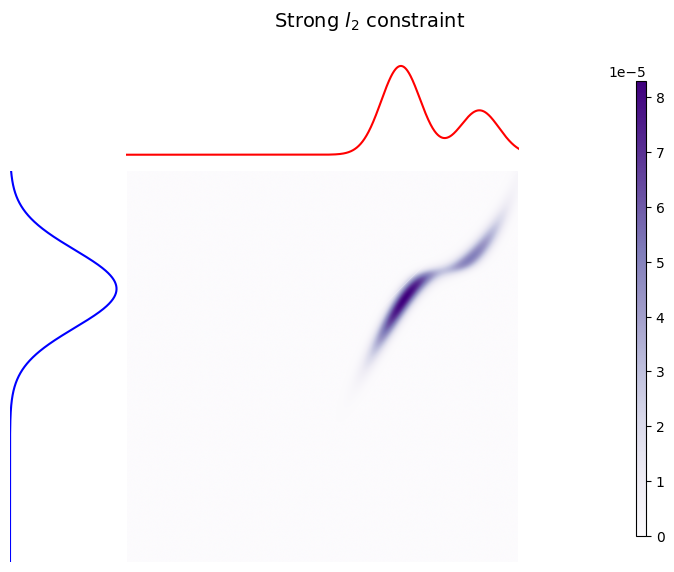

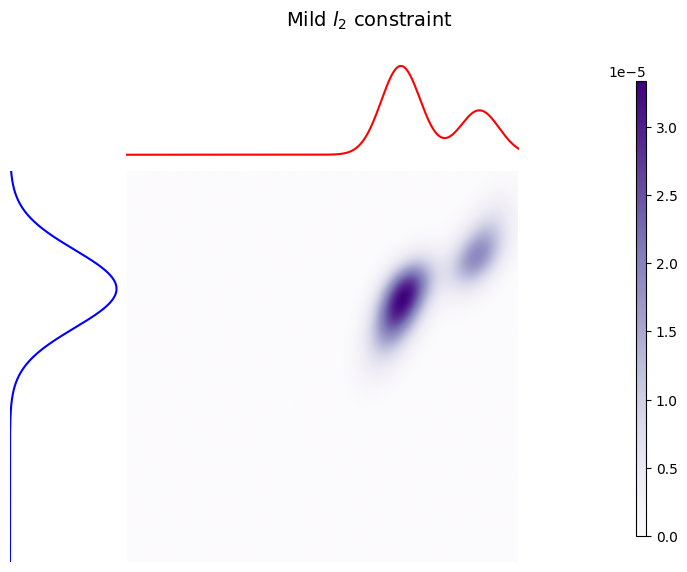

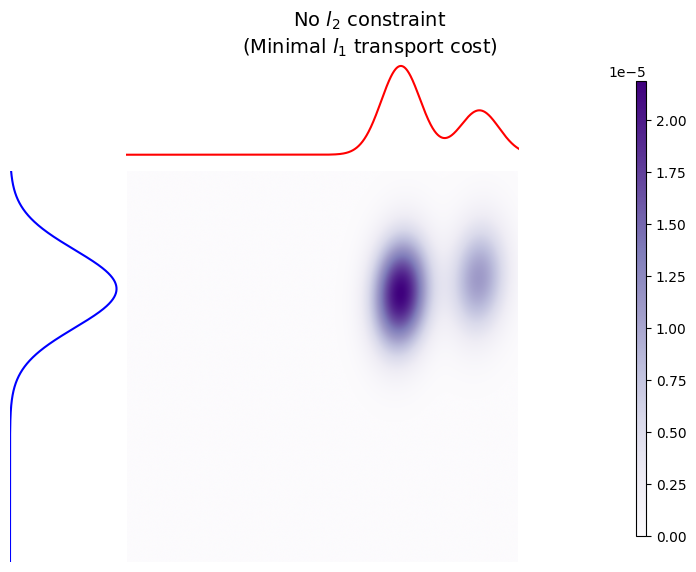

In [5]:
# === Problem setup ===
C = jnp.sum(
    (x[:, None, :] - y[None, :, :]) ** 2, axis=-1
)  # Squared Euclidean cost

r = gaussian(x.flatten(), 0.7, 0.1)
c = (
    2 * gaussian(x.flatten(), 0.7, 0.05) + gaussian(x.flatten(), 0.9, 0.05)
) / 3
r = r / jnp.sum(r)
c = c / jnp.sum(c)

# Constraint: use L2-style with identity matrix as surrogate
D = jnp.eye(n_samples)
Dm_list = [D]  # single constraint matrix in list form

# Regularizations to try
regs = [0.0001, 0.001, 0.01, 0.1]
titles = [
    "Binding $l_2$ constraint\n(Minimal $l_2$ transport cost)",
    "Strong $l_2$ constraint",
    "Mild $l_2$ constraint",
    "No $l_2$ constraint\n(Minimal $l_1$ transport cost)",
]

for i, reg in enumerate(regs):
    eta = 1.0 / reg
    # _, _, transport_constrained, _ = constrained_sinkhorn(
    #     C, Dm_list, r, c, eta=eta, N_sinkhorn=300
    # )
    _, _, transport_constrained, _ = constrained_sinkhorn(
        C,
        D_ineq=[],  # wrap as list
        D_eq=[D],  # wrap as list
        r=r,
        c=c,
        eta=eta,
        N_sinkhorn=300,
    )
    fig = plt.figure(figsize=(6.5, 6.5))
    gs = gridspec.GridSpec(
        2,
        2,
        width_ratios=[4, 1],
        height_ratios=[1, 4],
        wspace=0.05,
        hspace=0.05,
    )

    # Top histogram: target (c)
    ax_top = plt.subplot(gs[0, 0])
    ax_top.plot(jnp.arange(len(c)), c, color="red")
    ax_top.set_xlim(0, len(c))
    ax_top.axis("off")

    # Left-side histogram: source (r)
    ax_left = plt.subplot(gs[1, 0])
    ax_left = ax_left.inset_axes([-0.3, 0, 0.3, 1])  # shifted to the left
    ax_left.plot(r, jnp.arange(len(r)), color="blue")
    ax_left.set_ylim(0, len(r))
    ax_left.set_xlim(0, jnp.max(r) * 1.1)
    ax_left.axis("off")

    # Main transport plan
    ax_main = plt.subplot(gs[1, 0])
    im = ax_main.imshow(transport_constrained, cmap="Purples", origin="lower")
    ax_main.axis("off")

    # Colorbar
    cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
    plt.colorbar(im, cax=cbar_ax)

    # Title
    plt.suptitle(titles[i], fontsize=14, y=0.96)
    plt.show()

#### 2.3. Two-Dimensional Constrained Optimal Transport

We now test the Sinkhorn-type algorithm on a 2D transport problem. The source and target are Gaussian point clouds in \(\mathbb{R}^2\), and we enforce random linear constraints during transport.

This simulates a real-world case where spatial distributions must follow structure or fairness conditions.

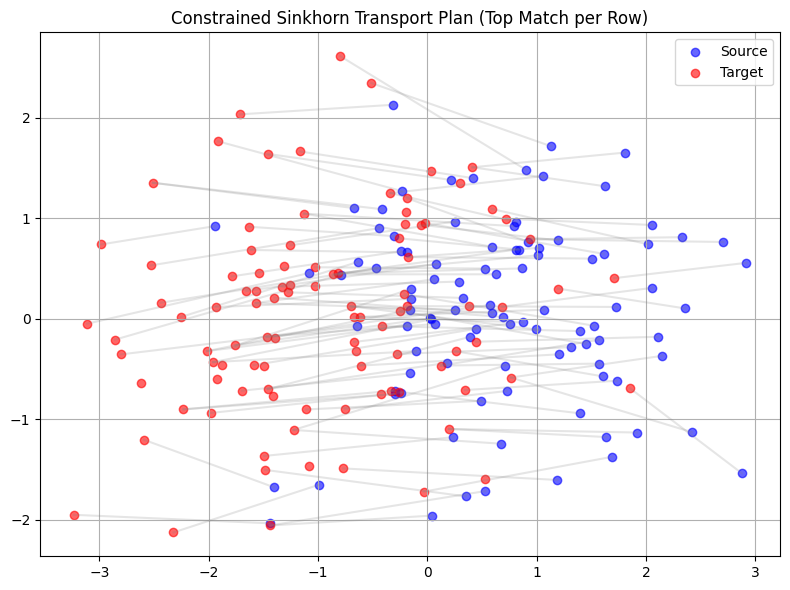

In [6]:
r = jnp.ones(n) / n
c = jnp.ones(n) / n

# === 2. Cost matrix: squared Euclidean ===


def pairwise_sq_dist(A, B):
    A_norm = jnp.sum(A**2, axis=1).reshape((-1, 1))
    B_norm = jnp.sum(B**2, axis=1).reshape((1, -1))
    return A_norm + B_norm - 2.0 * A @ B.T


C = pairwise_sq_dist(X, Y)
C = C / jnp.mean(C)  # Normalize to avoid overflow in exp(-eta * C)

# === 3. Constraint matrices (rescaled) ===
key, k1, k2 = jax.random.split(key, 3)
D_I = jax.random.uniform(k1, (n, n))
D_E = jax.random.uniform(k2, (n, n))
t_I, t_E = 0.5, 0.5

D1 = 0.1 * (D_I - t_I) / n
D2 = 0.1 * (D_E - t_E) / n

# === 4. Constrained Sinkhorn Algorithm ===


def constrained_sinkhorn(
    C,
    D_ineq=[],
    D_eq=[],
    r=None,
    c=None,
    eta=30,
    N_sinkhorn=100,
    N_newton=0,
    rho=1e-3,
    xinit=None,
    yinit=None,
    ainit=None,
    return_iterates=None,
):
    n = C.shape[0]
    m_ineq = len(D_ineq)
    m_eq = len(D_eq)
    m = m_ineq + m_eq

    Dm_list = D_ineq + D_eq
    Dm_tensor = jnp.stack(Dm_list)
    v = jnp.concatenate([jnp.ones(n), -jnp.ones(n), jnp.zeros(m)])

    x = jnp.zeros(n) if xinit is None else xinit
    y = jnp.zeros(n) if yinit is None else yinit
    a_ineq = jnp.zeros(m_ineq)
    a_eq = jnp.zeros(m_eq)

    def get_full_a():
        return jnp.concatenate([a_ineq, a_eq])

    z = None

    for i in range(N_sinkhorn):
        a = get_full_a()
        dual_term = jnp.sum(a[:, None, None] * Dm_tensor, axis=0)

        P = jnp.exp(-eta * (C - dual_term - x[:, None] - y[None, :]))
        x += (jnp.log(r) - jnp.log(jnp.clip(P @ jnp.ones(n), 1e-8))) / eta

        dual_term = jnp.sum(a[:, None, None] * Dm_tensor, axis=0)
        P = jnp.exp(-eta * (C - dual_term - x[:, None] - y[None, :]))
        y += (jnp.log(c) - jnp.log(jnp.clip(P.T @ jnp.ones(n), 1e-8))) / eta

        Ku = P @ jnp.ones(n)
        residuals = jnp.array([Dm @ Ku - r for Dm in Dm_list])
        grad_ineq = jnp.array([jnp.sum(res) for res in residuals[:m_ineq]])
        grad_eq = jnp.array([jnp.sum(res) for res in residuals[m_ineq:]])

        a_ineq = jnp.maximum(a_ineq + 0.5 * grad_ineq, 0.0)
        a_eq = a_eq + 0.5 * grad_eq

        if return_iterates is not None:
            return_iterates.append(P)

    return x, y, P, (a_ineq, a_eq)


# === 5. Run the algorithm ===
x, y, P_constrained, (a_ineq, a_eq) = constrained_sinkhorn(
    C, [D1], [D2], r, c, eta=30, N_sinkhorn=100
)

# === 6. Plot result ===
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c="blue", label="Source", alpha=0.6)
plt.scatter(Y[:, 0], Y[:, 1], c="red", label="Target", alpha=0.6)

for i in range(n):
    j = jnp.argmax(P_constrained[i])
    plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], "gray", alpha=0.2)

plt.title("Constrained Sinkhorn Transport Plan (Top Match per Row)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Comparison of Algorithm 1 (Sinkhorn-type) vs. Algorithm 2 (Sinkhorn-Newton-Sparse) on 2D Synthetic Data

To evaluate the behavior of the proposed methods in a more realistic scenario, we compare **Algorithm 1** and **Algorithm 2** on a 2D optimal transport problem with linear constraints.

- **Algorithm 1: Sinkhorn-type method**  
  This algorithm performs iterative Bregman projections to satisfy marginal and constraint requirements. It corresponds to the first phase of the method proposed in the paper.

- **Algorithm 2: Sinkhorn-Newton-Sparse (SNS)**  
  This variant includes an additional Newton refinement stage after the Sinkhorn iterations. It accelerates convergence and provides a more accurate enforcement of the constraints.

For each method, we monitor:
- **Transport Cost Error**: absolute difference between the current cost and that of the final converged plan (used as a reference).
- **Constraint Violation**: the total violation of inequality and equality constraints, computed using the projected transport plan.

Both methods are tested over 100 iterations on the **2D Gaussian blobs dataset** described earlier in the tutorial. The plots below illustrate the convergence behavior in terms of cost and violation:

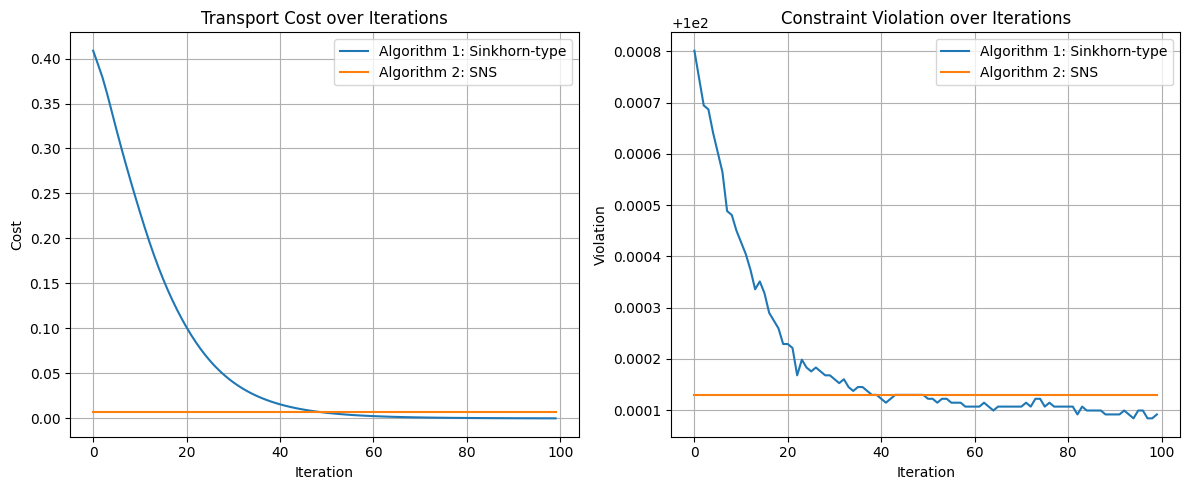

In [7]:
# === Algorithm 1: Sinkhorn-type only ===
cost_algo1 = []
viol_algo1 = []

for i in range(100):
    _, _, P1, _ = constrained_sinkhorn(
        C, [D1], [D2], r, c, eta=30, N_sinkhorn=i + 1, N_newton=0
    )
    cost = abs(jnp.sum(P1 * C) - jnp.sum(P_constrained * C))
    viol_ineq = jnp.sum(jnp.maximum(P1 @ D1.T - r[:, None], 0.0))
    viol_eq = jnp.sum(jnp.abs(P1 @ D2.T - r[:, None]))
    cost_algo1.append(float(cost))
    viol_algo1.append(float(viol_ineq + viol_eq))

# === Algorithm 2: Sinkhorn-Newton-Sparse (SNS) ===
cost_algo2 = []
viol_algo2 = []

for i in range(100):
    _, _, P2, _ = constrained_sinkhorn(
        C, [D1], [D2], r, c, eta=30, N_sinkhorn=50, N_newton=i + 1
    )
    cost = abs(jnp.sum(P2 * C) - jnp.sum(P_constrained * C))
    viol_ineq = jnp.sum(jnp.maximum(P2 @ D1.T - r[:, None], 0.0))
    viol_eq = jnp.sum(jnp.abs(P2 @ D2.T - r[:, None]))
    cost_algo2.append(float(cost))
    viol_algo2.append(float(viol_ineq + viol_eq))

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cost_algo1, label="Algorithm 1: Sinkhorn-type")
plt.plot(cost_algo2, label="Algorithm 2: SNS")
plt.title("Transport Cost over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(viol_algo1, label="Algorithm 1: Sinkhorn-type")
plt.plot(viol_algo2, label="Algorithm 2: SNS")
plt.title("Constraint Violation over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Violation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()